In [2]:

import mrcfile 
import numpy as np
import torchvision.datasets
import datetime
import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
# import transformers
import pytorch_lightning as pl
# import supervision as sv
from transformers import DetrConfig, DetrForObjectDetection, DetrImageProcessor, DetrForSegmentation, ConditionalDetrForObjectDetection,ConditionalDetrConfig,ConditionalDetrForSegmentation
import torch
import sys 
sys.path.append("/home/tyfei/cyroem")
import importlib 
import utils
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import modules
importlib.reload(utils)
importlib.reload(modules)
import json

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## test small batch

In [3]:
path = "/mnt/panbz/lab/transforemer_model/train_data/training/results/deformable/fold6_test"
with open(os.path.join(path, "config.json"), "r") as f:
    configs = json.load(f)
# configs["data"]["image_path"] = "/mnt/panbz/lab/transforemer_model/train_data/training/data/"
# configs["data"]["annotation_path_train"] = "/mnt/panbz/lab/transforemer_model/train_data/training/data/annotations/sllt0039_9.pkl"
# configs["data"]["annotation_path_val"] = "/mnt/panbz/lab/transforemer_model/train_data/training/data/annotations/sllt0051_9.pkl"

In [4]:
if configs["model"]["stage"] == "stage 1":
    ds = utils.get_stage1_dataset(configs)
elif configs["model"]["stage"] == "stage 2":
    ds = utils.get_stage2_dataset(configs)
elif configs["model"]["stage"] == "stage mask":
    ds = utils.get_stageMask_dataset(configs)

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
6 5
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
6 2


In [5]:
model = utils.getModel(configs)

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

model at stage  stage 1


In [6]:
dl = ds.train_dataloader()
for i, j in enumerate(dl):
    break

In [7]:
optim = model.configure_optimizers() 

In [9]:
optim = optim["optimizer"]

In [10]:
model = model.cuda(0)
for i in range(2000):
    optim.zero_grad()
    loss, loss_dict = model.common_step_stage1(j[0]) 
    loss.backward()
    optim.step()
    if i % 10 == 0:
        print(loss_dict)

{'loss_ce': tensor(0.8556, device='cuda:0', grad_fn=<MulBackward0>), 'loss_bbox': tensor(0.1075, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.9491, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(283.5000, device='cuda:0')}
{'loss_ce': tensor(0.3354, device='cuda:0', grad_fn=<MulBackward0>), 'loss_bbox': tensor(0.0504, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.5836, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(283.5000, device='cuda:0')}
{'loss_ce': tensor(0.3370, device='cuda:0', grad_fn=<MulBackward0>), 'loss_bbox': tensor(0.0519, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.6604, device='cuda:0', grad_fn=<DivBackward0>), 'cardinality_error': tensor(283.5000, device='cuda:0')}
{'loss_ce': tensor(0.2531, device='cuda:0', grad_fn=<MulBackward0>), 'loss_bbox': tensor(0.0304, device='cuda:0', grad_fn=<DivBackward0>), 'loss_giou': tensor(0.5156, device='cuda:0', grad_fn=<DivBackward0

KeyboardInterrupt: 

In [2]:

import mrcfile 
import numpy as np
import torchvision.datasets
import datetime
import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
# import transformers
import pytorch_lightning as pl
# import supervision as sv
from transformers import DetrConfig, DetrForObjectDetection, DetrImageProcessor, DetrForSegmentation, ConditionalDetrForObjectDetection
import torch
import sys 
sys.path.append("/home/tyfei/cyroem")
import importlib 
import utils
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import modules
importlib.reload(utils)
importlib.reload(modules)

<module 'modules' from '/home/feity/cryoem/modules.py'>

In [2]:
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from functools import partial
import numpy as np
import sys 
import os
sys.path.append("/home/tyfei/cyroem")
import utils
import pycocotools
import json
import torch
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from transformers import DetrForObjectDetection, DetrImageProcessor, DetrForSegmentation
import modules
from torch_geometric.data import Data 

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetWithAdditionalInput(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, additional_input_dim=10):
        super(UNetWithAdditionalInput, self).__init__()

        # Contracting path (Encoder)
        self.enc1 = self.double_conv(in_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Process additional input
        self.additional_fc = nn.Sequential(
            nn.Linear(additional_input_dim, 1024),  # Map additional input to the same dimension as bottleneck
            # nn.ReLU(inplace=True)
        )

        # Expanding path (Decoder)
        self.upconv4 = self.upconv(2048, 512)  # Bottleneck + Additional input (1024 + 1024 = 2048)
        self.dec4 = self.double_conv(1024, 512)

        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.double_conv(512, 256)

        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.double_conv(256, 128)

        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.double_conv(128, 64)

        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        """Double convolution layers with ReLU activation."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU6(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU6(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        """Upsample the feature map using transpose convolution."""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def crop_and_concat(self, upsampled, bypass):
        """Crop the bypass connection to match the size of the upsampled feature map."""
        _, _, h, w = upsampled.size()
        bypass = F.interpolate(bypass, size=(h, w), mode="bilinear", align_corners=True)
        return torch.cat((upsampled, bypass), dim=1)

    def forward(self, x, additional_input):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))

        # Process additional input
        additional_input_processed = self.additional_fc(additional_input)
        additional_input_processed = additional_input_processed.unsqueeze(-1).unsqueeze(-1)  # Reshape to (batch, 1024, 1, 1)
        additional_input_processed = additional_input_processed.expand(-1, -1, bottleneck.size(2), bottleneck.size(3))  # Match spatial dims

        # Concatenate bottleneck and additional input
        bottleneck = torch.cat((bottleneck, additional_input_processed), dim=1)

        # Decoder
        up4 = self.upconv4(bottleneck)
        concat4 = self.crop_and_concat(up4, enc4)
        dec4 = self.dec4(concat4)

        up3 = self.upconv3(dec4)
        concat3 = self.crop_and_concat(up3, enc3)
        dec3 = self.dec3(concat3)

        up2 = self.upconv2(dec3)
        concat2 = self.crop_and_concat(up2, enc2)
        dec2 = self.dec2(concat2)

        up1 = self.upconv1(dec2)
        concat1 = self.crop_and_concat(up1, enc1)
        dec1 = self.dec1(concat1)

        # Output layer
        output = self.out_conv(dec1)
        output = output.squeeze(1)  # Remove channel dimension
        # output = torch.sigmoid(output)  # Sigmoid activation for binary classification
        return output

# Test the modified U-Net model
if __name__ == "__main__":
    # Create the U-Net model with additional input
    model = UNetWithAdditionalInput(in_channels=3, out_channels=1, additional_input_dim=272)

    # Create a random input tensor with size (batch_size=1, channels=3, height=800, width=800)
    input_tensor = torch.randn(1, 3, 800, 800)

    # Create a random additional input tensor with size (batch_size=1, additional_input_dim=10)
    additional_input = torch.randn(1, 272)

    # Perform a forward pass
    output = model(input_tensor, additional_input)

    # Check the output size
    print("Input shape: ", input_tensor.shape)
    print("Additional input shape: ", additional_input.shape)
    print("Output shape:", output.shape)


Input shape:  torch.Size([1, 3, 800, 800])
Additional input shape:  torch.Size([1, 272])
Output shape: torch.Size([1, 800, 800])


In [13]:
import importlib
import modules
import utils
# model = modules.UNet(3, 1, 272, False)
# model(input_tensor, additional_input)

In [14]:
graph = torch.load("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_boxes_label_detr_all.pth") 
retdict = torch.load("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2dataset/TS_031_mask.pth")
model = utils.loadModel("checkpoints/stage_2_mask_new", "last.ckpt")

/tmp/ipykernel_1035245/2315025304.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load("/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/stage2datas

model at stage  stage mask


/home/feity/cryoem/utils.py:450: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load(configs["model"]["load"], map_location="cpu")
/home/feity/cryoem/utils.py:813: 

In [15]:
retdict

{'embed': tensor([[-0.7758,  0.0840, -0.5103,  ..., -0.0757,  0.3651, -2.0675],
         [-0.8708,  0.3526, -0.1641,  ...,  0.0312,  0.1059, -1.8408],
         [-1.1386,  0.2005, -0.1643,  ..., -0.0675,  0.1944, -1.9651],
         ...,
         [-1.1132,  0.3688,  0.5346,  ..., -0.3186, -1.1371, -1.6117],
         [-1.1785,  0.4808,  0.9233,  ...,  0.0394, -1.1852, -2.2074],
         [-1.5013,  0.5166,  1.4802,  ..., -0.3030, -1.6792, -1.8967]]),
 'pixel_values': tensor([[[[0.4591, 0.5027, 0.5903,  ..., 0.0000, 0.0000, 0.0000],
           [0.4859, 0.5037, 0.5378,  ..., 0.0000, 0.0000, 0.0000],
           [0.5875, 0.5171, 0.4590,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.6332, 0.7162, 0.6776,  ..., 0.0000, 0.0000, 0.0000],
           [0.5970, 0.6315, 0.6131,  ..., 0.0000, 0.0000, 0.0000],
           [0.5596, 0.4961, 0.4912,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.4591, 0.5027, 0.5903,  ..., 0.0000, 0.0000, 0.0000],
           [0.4859, 0.5037, 0.5378,  ..., 0.0

In [16]:
need = []
for i in retdict["sample_mapping"]:
    if retdict["sample_mapping"][i] == 20:
        need.append(i)

In [17]:
embed = retdict["embed"]
embed = embed[need]

In [18]:
mask = retdict["masks"][need]
mask.shape

torch.Size([259, 800, 800])

In [19]:
s = mask.sum(axis=[1, 2])
mask = mask[s>10000]#.to(1)
embed = embed[s>10000]#.to(1)
s = mask.sum(axis=[1, 2])
mask = mask[s<18000].to("cpu")
embed = embed[s<18000].to("cpu")

In [20]:
mask.shape

torch.Size([3, 800, 800])

In [24]:
pixel_values = retdict["pixel_values"][20] 
pixel_values = pixel_values.unsqueeze(0).repeat(3, 1, 1, 1).to("cpu")

In [25]:
model = model.to("cpu")
out = model(pixel_values = pixel_values.float(), stage_2_embeds = embed.float())


In [10]:
def focal_loss(inputs, targets, alpha: float = 0.75, gamma: float = 2.0):
    ce_loss = F.binary_cross_entropy(inputs, targets, reduction="none")
        # add modulating factor
    p_t = inputs.detach() * targets + (1 - inputs.detach()) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    return loss.sum()

In [ ]:
def sigmoid_focal_loss(inputs, targets, num_boxes=None, alpha: float = 0.25, gamma: float = 2):
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs (`torch.FloatTensor` of arbitrary shape):
            The predictions for each example.
        targets (`torch.FloatTensor` with the same shape as `inputs`)
            A tensor storing the binary classification label for each element in the `inputs` (0 for the negative class
            and 1 for the positive class).
        alpha (`float`, *optional*, defaults to `0.25`):
            Optional weighting factor in the range (0,1) to balance positive vs. negative examples.
        gamma (`int`, *optional*, defaults to `2`):
            Exponent of the modulating factor (1 - p_t) to balance easy vs hard examples.

    Returns:
        Loss tensor
    """
    prob = inputs.sigmoid()
    ce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    # add modulating factor
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss
        
    if num_boxes is None:
        num_boxes = targets.shape[0]

    return loss.mean(1).sum() / num_boxes

In [35]:
model = modules.UNet(3, 1, 272, False)
# model = UNetWithAdditionalInput(3, 1, 272)
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
model = model.to(1)
# cri = focal_loss
cri = nn.BCELoss()
for i in range(256):
    opt.zero_grad()
    out = model(pixel_values.float(), embed)
    # loss = F.binary_cross_entropy_with_logits(out, mask.float())
    loss = sigmoid_focal_loss(out, mask.float(), 6)
    loss.backward()
    opt.step()
    if i % 10 == 0:
        print(loss.item())

72.72940063476562
7.901914119720459
4.396106719970703
3.924569606781006
1.4608027935028076
0.7827390432357788
0.9118880033493042
1.9047420024871826
1.2065860033035278
0.6309958696365356
0.41290396451950073
0.33044591546058655
0.2778283953666687
0.250027060508728
0.2131613940000534
0.21738949418067932
3.355851650238037
1.8730990886688232
0.9257339239120483
0.5306844711303711
0.3762527406215668
0.324312686920166
0.2685006856918335
0.23973487317562103
0.21667061746120453
0.20141124725341797


In [26]:
out[:, :10]

tensor([[[-1.8650, -2.4607, -2.8178,  ..., -2.2239, -2.0197, -1.5972],
         [-2.3235, -2.9971, -3.3607,  ..., -3.3405, -2.9959, -2.2567],
         [-2.4385, -2.9152, -3.1466,  ..., -3.8580, -3.4478, -2.5579],
         ...,
         [-2.4914, -2.9041, -3.0347,  ..., -4.1267, -3.6660, -2.6856],
         [-2.4903, -2.9488, -3.0913,  ..., -4.1448, -3.6802, -2.6932],
         [-2.5066, -2.9884, -3.1372,  ..., -4.1579, -3.6904, -2.6986]],

        [[-1.9906, -2.5855, -2.9450,  ..., -2.2616, -2.0787, -1.6826],
         [-2.4563, -3.1129, -3.4700,  ..., -3.3387, -3.0294, -2.3316],
         [-2.5704, -3.0147, -3.2308,  ..., -3.8260, -3.4601, -2.6237],
         ...,
         [-2.6292, -3.0086, -3.1177,  ..., -3.9838, -3.5953, -2.7110],
         [-2.6280, -3.0561, -3.1777,  ..., -3.9828, -3.5948, -2.7112],
         [-2.6456, -3.0992, -3.2278,  ..., -3.9812, -3.5938, -2.7108]],

        [[-1.7027, -2.2645, -2.6129,  ..., -2.0436, -1.8313, -1.4146],
         [-2.1675, -2.8054, -3.1653,  ..., -3

In [27]:
out.shape
out = torch.sigmoid(out)
out = out.cpu().detach().numpy()

In [28]:
import numpy as np 
import matplotlib.pyplot as plt

In [29]:
np.max(out), np.min(out)

(0.3641956, 0.0021076498)

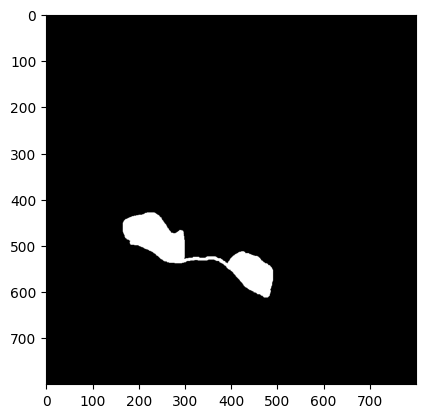

In [30]:
q = mask.cpu().float().numpy()
plt.imshow(q[2], cmap="gray")

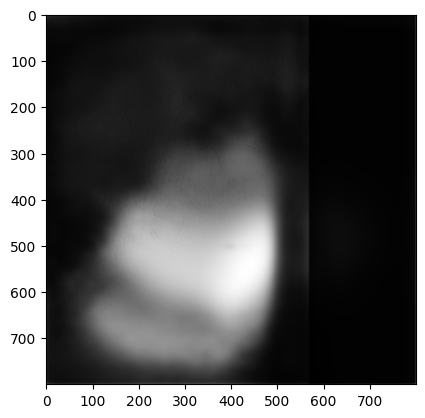

In [31]:
import matplotlib.pyplot as plt 

out1 = out[2]
plt.imshow(out1, cmap="gray")